# Package Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Global Configurations

In [0]:
ATTRIBUTES = {
  'game_ID' : 1,
  'date' : 2,
  'player_ID' : 3,
  'player' : 4,
  'team' : 5,
  'position' : 9,
  'salary' : 11,
  'points' : 13
}

COMPOSITION = {
  'C' : 2,
  'G' : 2, 
  'D' : 2,
  'W' : 3
}

INDICES = [val for key, val in ATTRIBUTES.items()]
CURRENT_DATE = None
PERCENT_SUPERSTARS = 10
MAX_NUMBER_OF_SUPERSTARS = 4
BUDGET = 50000
TEAM = []

# 1. Load & Pre-Process Data

#### 1.1 Read Raw Data

In [0]:
# File location and type
file_location = "/FileStore/tables/DataTable.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

print("ORIGINAL DATASET: \n\t rows = {} | attributes = {}".format(df.count(), len(df.columns)))

ORIGINAL DATASET: 
 rows = 46360 | attributes = 15

#### 1.2 Convert to RDD & Cache

In [0]:
RDD = df.rdd.map(list)
RDD.cache()

Out[286]: PythonRDD[18153] at RDD at PythonRDD.scala:58

#### 1.3 Extract the Required Columns from RDD

In [0]:
# extract only relevant columns
RDD_filtered_by_column = RDD.map(lambda entry: [entry[i] for i in INDICES])

# update attribute indices
ATTRIBUTES = {
  'game_ID' : 0,
  'date' : 1,
  'player_ID' : 2,
  'player' : 3,
  'team' : 4,
  'position' : 5,
  'salary' : 6,
  'points' : 7
}

#### 1.4 Remove Rows Containing Invalid Entries

In [0]:
# filter out rows that contain invalid 'position' and 'points' entries
RDD_cleaned = RDD_filtered_by_column.filter(lambda entry: entry[ATTRIBUTES['position']] != "#N/A" 
                                          and entry[ATTRIBUTES['points']] != "#N/A" 
                                          and entry[ATTRIBUTES['salary']] != "#N/A")
data = RDD_cleaned.collect()
print("CLEANED DATASET: \n\t rows = {} | attributes = {}".format(len(data), len(data[0])))

CLEANED DATASET: 
 rows = 44183 | attributes = 8

#### 1.5 Group Rows by Player ID

In [0]:
# group rows by 'player_ID'
RDD_paired_by_player = RDD_cleaned.map(lambda entry: [entry[ATTRIBUTES['player_ID']], entry])
RDD_grouped_by_player = RDD_paired_by_player.groupByKey().mapValues(list).map(lambda entry: list(entry))
data = RDD_grouped_by_player.collect()
print("GROUPED DATASET (by PLAYER ID): \n\t rows = {} | attributes = {}".format(len(data), len(data[0])))

GROUPED DATASET (by PLAYER ID): 
 rows = 969 | attributes = 2

In [0]:
RDD_player_all_info = RDD_grouped_by_player.filter(lambda entry: entry[0] == 3756).flatMap(lambda x: x[1])
RDD_player_game_info = RDD_player_all_info.filter(lambda entry: entry[ATTRIBUTES['date']] == '2019-10-02')
RDD_player_game_info.collect()[0][ATTRIBUTES['points']]

Out[310]: 4.1

#### 1.6 Sort Rows by Date

In [0]:
# sort rows by 'date' for each player
RDD_sorted_by_date = RDD_grouped_by_player.map(lambda entry: [entry[0], sorted(entry[1], key = lambda x: x[ATTRIBUTES['date']])])
data = RDD_sorted_by_date.collect()
print("GROUPED DATASET (by PLAYER ID) (sorted by GAME DATE): \n\t rows = {} | attributes = {}".format(len(data), len(data[0])))

GROUPED DATASET (by PLAYER ID) (sorted by GAME DATE): 
 rows = 969 | attributes = 2

# 2. Compute Running Averages of Fantasy Points and Salaries (Cost) for Each Player

In [0]:
def compute_running_average_points(entry):
  
  """
    Returns the following attributes for each player (for each game):
    
      - game_ID
      - most recent game date
      - ID
      - name
      - team
      - position
      - salary in most recent game
      - points in most recent game
      - running average of points up to most recent game
      
    ** Assumes that entries for each player are sorted by date.
  """
  
  ID, rows = tuple(entry)
  count = 0
  total_points = 0
  total_cost = 0
  
  for row in rows:
    count += 1
    total_points += float(row[ATTRIBUTES['points']])
    row.append(float(total_points) / count)
    row[ATTRIBUTES['salary']] = int(row[ATTRIBUTES['salary']])
    
  return [ID, rows]

def compute_running_average_of_points_and_cost(entry):
  
  """
    Returns the following attributes for each player (for each game):
    
      - game_ID
      - most recent game date
      - ID
      - name
      - team
      - position
      - salary in most recent game
      - points in most recent game
      - running average of points up to most recent game
      - running average of salary up to most recent game
      
    ** Assumes that entries for each player are sorted by date.
  """
  
  ID, rows = tuple(entry)
  count = 0
  total_points = 0
  total_cost = 0
  
  for row in rows:
    count += 1
    total_points += float(row[ATTRIBUTES['points']])
    total_cost += int(row[ATTRIBUTES['salary']])
    row.append(float(total_points) / count)
    row.append(float(total_cost) / count)
    row[ATTRIBUTES['salary']] = int(row[ATTRIBUTES['salary']])
    
  #return [ID, rows[-1] + [total_points, total_cost]]
  return [ID, rows]

RDD_with_running_averages = RDD_sorted_by_date.map(compute_running_average_of_points_and_cost)
RDD_average_points = RDD_sorted_by_date.map(compute_running_average_points)

# add attribute-index mappings
ATTRIBUTES['average_points'] = 8
ATTRIBUTES['average_salary'] = 9

# 3. Evaluate Picking Strategies over the Full Season

#### Define Utility Functions

In [0]:
def filter_by_current_date(entry):
  
  ID, rows = tuple(entry)
  new_rows = []
  
  for row in rows:
    if row[ATTRIBUTES['date']] < CURRENT_DATE:
      new_rows.append(row)
      
  if len(new_rows):
    return [ID, new_rows[-1]]
  else:
    return [ID, []]
  
def compute_undervaluedness(entry):

  ID, row = tuple(entry)
  undervalued, UV_index_absolute, UV_index_relative  = False, 0, 0 
  curr_cost = int(row[ATTRIBUTES['salary']])
  average_cost = row[ATTRIBUTES['average_salary']]

  if curr_cost < average_cost:
    undervalued = True

  UV_index_absolute = curr_cost - average_cost
  UV_index_relative = (curr_cost - average_cost) / average_cost
  row += [undervalued, UV_index_absolute, UV_index_relative]

  return [ID, row]

def find_available_players(entry):
  
  ID, rows = tuple(entry)
  
  for row in rows:
    if row[ATTRIBUTES['date']] == CURRENT_DATE:
      return True
    
  return False

def filter_by_availability(entry):
  
  position, players = tuple(entry)
  
  for player in players:
    ID, _ = tuple(player)
    if RDD_available_players.filter(lambda player: player == ID):
      return True
    
  return False

def find_super_stars(entry):
  ID, rows = tuple(entry)
  superStars = []
  
  nStars = int(len(rows)/PERCENT_SUPERSTARS)
  
  i = 0
  while i < nStars:
    superStars.append(rows[i])
    i += 1
  
  return [ID, superStars]

def add_superstars_to_team(candidates, num_superstars):
  
  global COMPOSITION
  
  team = []
  remaining_budget = BUDGET
  composition = COMPOSITION
      
  for player in candidates[:num_superstars]:
      name = player[1][ATTRIBUTES['player']]
      salary = player[1][ATTRIBUTES['salary']]
      position = player[1][ATTRIBUTES['position']]
      remaining_budget -= salary
      team.append(player)
      composition[position] -= 1
      
  return team, remaining_budget, composition

def evaluate_team(date, team):
  
  total_points = 0
  
  for player in team:
    player_ID = player[1][ATTRIBUTES['player_ID']]
    RDD_player_all_info = RDD_grouped_by_player.filter(lambda entry: entry[0] == player_ID).flatMap(lambda x: x[1])
    RDD_player_game_info = RDD_player_all_info.filter(lambda entry: entry[ATTRIBUTES['date']] == date)
    info = RDD_player_game_info.collect()

    if len(info):
      points = info[0][ATTRIBUTES['points']]
      total_points += points
  
  return total_points

def extract_player_info_for_current_date(entry):
  
  ID, rows = tuple(entry)
  
  for row in rows:
    if row[ATTRIBUTES['date']] == CURRENT_DATE:
      return [ID, row]

#### 3.1 Determine all Game Dates in Cleaned Dataset

In [0]:
DATES = []

for row in RDD_cleaned.collect():
  date = row[ATTRIBUTES['date']]
  DATES.append(date)
  
# only keep unique dates & sort
DATES = sorted(list(set(DATES)), key = lambda x: (int(x.split('-')[0]), int(x.split('-')[1]), int(x.split('-')[2])))

#### 3.2 Compute Fantasy Points Collected over Entire Season with "Baseline" Strategy

In [0]:
BASELINE_FPs = []

def create_baseline_team(date):
  
  global ATTRIBUTES, CURRENT_DATE, COMPOSITION
  
  CURRENT_DATE = date
  ideal_cost = BUDGET / 9
  
  # extract info for players playing on current date
  RDD_available_players = RDD_with_running_averages.filter(find_available_players)
  RDD_available_players_info = RDD_available_players.map(extract_player_info_for_current_date)
  
  # filter out un-afforable players
  RDD_affordable_players_info = RDD_available_players_info.filter(lambda entry: entry[1][ATTRIBUTES['salary']] <= ideal_cost)
  
  # group players by position & sort
  RDD_paired_by_position = RDD_affordable_players_info.map(lambda entry: [entry[1][ATTRIBUTES['position']], entry])
  RDD_grouped_by_position = RDD_paired_by_position.groupByKey().mapValues(list).map(lambda entry: list(entry))
  RDD_grouped_by_position_sorted = RDD_grouped_by_position.map(lambda entry: [entry[0], sorted(entry[1], 
                                                                                               key = lambda x:x[1][ATTRIBUTES['salary']], 
                                                                                               reverse = True)])
  
  COMPOSITION = {
    'C' : 2,
    'G' : 2, 
    'D' : 2,
    'W' : 3
  }

  team = []
  ROSTER = RDD_grouped_by_position_sorted.collect()

  # pick players using team composition requirements
  for position, quantity in COMPOSITION.items():
    RDD_selected_players = RDD_grouped_by_position_sorted.filter(
      lambda entry: entry[0] == position).flatMap(
      lambda entry: entry[1][:quantity])
    team += RDD_selected_players.collect()
    
  return team

for i, date in enumerate(DATES[1:]):
  print("completed " + str(i + 1) + " of " + str(len(DATES)), end = "\r")
  team = create_baseline_team(date)
  BASELINE_FPs.append(evaluate_team(date, team))

completed 1 of 189completed 2 of 189completed 3 of 189completed 4 of 189completed 5 of 189completed 6 of 189completed 7 of 189completed 8 of 189completed 9 of 189completed 10 of 189completed 11 of 189completed 12 of 189completed 13 of 189completed 14 of 189completed 15 of 189completed 16 of 189completed 17 of 189completed 18 of 189completed 19 of 189completed 20 of 189completed 21 of 189completed 22 of 189completed 23 of 189completed 24 of 189completed 25 of 189completed 26 of 189completed 27 of 189completed 28 of 189completed 29 of 189completed 30 of 189completed 31 of 189completed 32 of 189completed 33 of 189completed 34 of 189completed 35 of 189completed 36 of 189completed 37 of 189completed 38 of 189completed 39 of 189completed 40 of 189completed 41 of 189completed 42 of 189completed 43 of 189completed 44 of 189completed 45 of 189completed 46 of 189completed 47 of 189completed 48 of 189completed 49 of 189completed 50 of 189completed 51 of 189completed 52 of 189completed 53 of 189completed 54 of 189completed 55 of 189completed 56 of 189completed 57 of 189completed 58 of 189completed 59 of 189completed 60 of 189completed 61 of 189completed 62 of 189completed 63 of 189completed 64 of 189completed 65 of 189completed 66 of 189completed 67 of 189completed 68 of 189completed 69 of 189completed 70 of 189completed 71 of 189completed 72 of 189completed 73 of 189completed 74 of 189completed 75 of 189completed 76 of 189completed 77 of 189completed 78 of 189completed 79 of 189completed 80 of 189completed 81 of 189completed 82 of 189completed 83 of 189completed 84 of 189completed 85 of 189completed 86 of 189completed 87 of 189completed 88 of 189completed 89 of 189completed 90 of 189completed 91 of 189completed 92 of 189completed 93 of 189completed 94 of 189completed 95 of 189completed 96 of 189completed 97 of 189completed 98 of 189completed 99 of 189completed 100 of 189completed 101 of 189completed 102 of 189completed 103 of 189completed 104 of 189completed 105 of 189completed 106 of 189completed 107 of 189completed 108 of 189completed 109 of 189completed 110 of 189completed 111 of 189completed 112 of 189completed 113 of 189completed 114 of 189completed 115 of 189completed 116 of 189completed 117 of 189completed 118 of 189completed 119 of 189completed 120 of 189completed 121 of 189completed 122 of 189completed 123 of 189completed 124 of 189completed 125 of 189completed 126 of 189completed 127 of 189completed 128 of 189completed 129 of 189completed 130 of 189completed 131 of 189completed 132 of 189completed 133 of 189completed 134 of 189completed 135 of 189completed 136 of 189completed 137 of 189completed 138 of 189completed 139 of 189completed 140 of 189completed 141 of 189completed 142 of 189completed 143 of 189completed 144 of 189completed 145 of 189completed 146 of 189completed 147 of 189completed 148 of 189completed 149 of 189completed 150 of 189completed 151 of 189completed 152 of 189completed 153 of 189completed 154 of 189completed 155 of 189completed 156 of 189completed 157 of 189completed 158 of 189completed 159 of 189completed 160 of 189completed 161 of 189completed 162 of 189completed 163 of 189completed 164 of 189completed 165 of 189completed 166 of 189completed 167 of 189completed 168 of 189completed 169 of 189completed 170 of 189completed 171 of 189completed 172 of 189completed 173 of 189completed 174 of 189completed 175 of 189completed 176 of 189completed 177 of 189completed 178 of 189completed 179 of 189completed 180 of 189completed 181 of 189completed 182 of 189completed 183 of 189completed 184 of 189completed 185 of 189completed 186 of 189completed 187 of 189completed 188 of 189

#### 3.3 Compute Fantasy Points Collected over Entire Season with "Superstar +  Undervalued" Strategy

In [0]:
SU_FPs = []

def create_superstar_and_undervalued_team(date, num_superstars = 1):
  
  global ATTRIBUTES, CURRENT_DATE, COMPOSITION
  
  CURRENT_DATE = date
  
  # produce subsets of RDD predating the given date
  RDD_filtered_by_date_super_stars = RDD_average_points.map(filter_by_current_date).filter(lambda x:x[1] != [])
  RDD_filtered_by_date_under_valued = RDD_with_running_averages.map(filter_by_current_date).filter(lambda x:x[1] != [])
  
  # order players by average points in decending order
  RDD_paired_by_position_super_stars = RDD_filtered_by_date_super_stars.map(lambda entry: [entry[1][ATTRIBUTES['position']], entry])
  RDD_grouped_by_position_super_stars = RDD_paired_by_position_super_stars.groupByKey().mapValues(list).map(lambda entry: list(entry))
  RDD_sorted_by_average_points_scored = RDD_grouped_by_position_super_stars.map(
                                      lambda entry: [entry[0], sorted(entry[1], 
                                                                      key = lambda x: -x[1][ATTRIBUTES['average_points']])])

  # compute undervaluedness
  RDD_with_undervaluedness = RDD_filtered_by_date_under_valued.map(compute_undervaluedness)

  # add attribute-index mappings
  ATTRIBUTES['undervalued'] = 10
  ATTRIBUTES['UV_index_absolute'] = 11
  ATTRIBUTES['UV_index_relative'] = 12 
  
  # group players by position & sort by undervaluedness
  RDD_paired_by_position_undervalue = RDD_with_undervaluedness.map(lambda entry: [entry[1][ATTRIBUTES['position']], entry])
  RDD_grouped_by_position_undervalue = RDD_paired_by_position_undervalue.groupByKey().mapValues(list).map(lambda entry: list(entry))
  RDD_sorted_by_undervaluedness = RDD_grouped_by_position_undervalue.map(
                                      lambda entry: [entry[0], sorted(entry[1], 
                                                                      key = lambda x: x[1][ATTRIBUTES['UV_index_absolute']])])
  
  # extract players available on current date
  RDD_available_superstars = RDD_grouped_by_player.filter(find_available_players).map(lambda x: x[0])
  RDD_available_undervalued = RDD_grouped_by_player.filter(find_available_players).map(lambda x: x[0])
  
  # filter players by availability 
  RDD_availability_for_possible_super_stars = RDD_sorted_by_average_points_scored.filter(lambda entry: entry)
  RDD_undervalued_filtered_by_availability = RDD_sorted_by_undervaluedness.filter(lambda entry: entry)
  RDD_super_stars_filtered_by_availability = RDD_availability_for_possible_super_stars.map(find_super_stars)
    
  # determine candidate superstar players first
  sorted_super_star_candidates = []
  if num_superstars:
    candidate_CsuperstarsRDD = RDD_super_stars_filtered_by_availability.filter(lambda entry: entry[0] == 'C').map(lambda entry: entry[1][:num_superstars]).collect()[0]
    candidate_WsuperstarsRDD = RDD_super_stars_filtered_by_availability.filter(lambda entry: entry[0] == 'W').map(lambda entry: entry[1][:num_superstars]).collect()[0]
    candidate_DsuperstarsRDD = RDD_super_stars_filtered_by_availability.filter(lambda entry: entry[0] == 'D').map(lambda entry: entry[1][:num_superstars]).collect()[0]
    candidate_GsuperstarsRDD = RDD_super_stars_filtered_by_availability.filter(lambda entry: entry[0] == 'G').map(lambda entry: entry[1][:num_superstars]).collect()[0]
    
    candidate_superstars = candidate_CsuperstarsRDD + candidate_WsuperstarsRDD + candidate_DsuperstarsRDD + candidate_GsuperstarsRDD
    sorted_super_star_candidates = sc.parallelize(candidate_superstars).sortBy(lambda x:-x[1][ATTRIBUTES['average_points']]).collect()
  
  # add superstars to team
  team, remaining_budget, composition = [], BUDGET, None
  COMPOSITION = {
      'C' : 2,
      'G' : 2, 
      'D' : 2,
      'W' : 3
  }
    
  if num_superstars:
    team, remaining_budget, composition = add_superstars_to_team(sorted_super_star_candidates, num_superstars)
    
  # use remaining budget to add undervalued players
  if num_superstars < 9:
    budget_per_player = remaining_budget / (9 - num_superstars + COMPOSITION['G'])
    goalie_budget = budget_per_player * 2
    skater_budget = budget_per_player

    for position, quantity in COMPOSITION.items():
      candidate_players = RDD_undervalued_filtered_by_availability.filter(lambda entry: entry[0] == position).map(lambda entry: entry[1]).collect()[0]
      for player in candidate_players:
        if COMPOSITION[position] == 0:
          break
        if player[1][ATTRIBUTES['salary']] <= skater_budget or player[1][ATTRIBUTES['position']] == 'G' and player[1][ATTRIBUTES['salary']] <= goalie_budget:
          name = player[1][ATTRIBUTES['player']]
          salary = player[1][ATTRIBUTES['salary']]
          position = player[1][ATTRIBUTES['position']]
          remaining_budget -= salary
          COMPOSITION[position] -= 1
          team.append(player)

  return team


for i, date in enumerate(DATES[1:]):
  FPs = []
  print("completed " + str(i + 1) + " of " + str(len(DATES)), end = "\r")
  for num_superstars in range(0, MAX_NUMBER_OF_SUPERSTARS + 1):
    team = create_superstar_and_undervalued_team(date, num_superstars)
    FPs.append(evaluate_team(date, team))
  SU_FPs.append(FPs)

completed 1 of 189completed 2 of 189completed 3 of 189completed 4 of 189completed 5 of 189completed 6 of 189completed 7 of 189completed 8 of 189completed 9 of 189completed 10 of 189completed 11 of 189completed 12 of 189completed 13 of 189completed 14 of 189completed 15 of 189completed 16 of 189completed 17 of 189completed 18 of 189completed 19 of 189completed 20 of 189completed 21 of 189completed 22 of 189completed 23 of 189completed 24 of 189completed 25 of 189completed 26 of 189completed 27 of 189completed 28 of 189completed 29 of 189completed 30 of 189completed 31 of 189completed 32 of 189completed 33 of 189completed 34 of 189completed 35 of 189completed 36 of 189completed 37 of 189completed 38 of 189completed 39 of 189completed 40 of 189completed 41 of 189completed 42 of 189completed 43 of 189completed 44 of 189completed 45 of 189completed 46 of 189completed 47 of 189completed 48 of 189completed 49 of 189completed 50 of 189completed 51 of 189completed 52 of 189completed 53 of 189completed 54 of 189completed 55 of 189completed 56 of 189completed 57 of 189completed 58 of 189completed 59 of 189completed 60 of 189completed 61 of 189completed 62 of 189completed 63 of 189completed 64 of 189completed 65 of 189completed 66 of 189completed 67 of 189completed 68 of 189completed 69 of 189completed 70 of 189completed 71 of 189completed 72 of 189completed 73 of 189completed 74 of 189completed 75 of 189completed 76 of 189completed 77 of 189completed 78 of 189completed 79 of 189completed 80 of 189completed 81 of 189completed 82 of 189completed 83 of 189completed 84 of 189completed 85 of 189completed 86 of 189completed 87 of 189completed 88 of 189completed 89 of 189completed 90 of 189completed 91 of 189completed 92 of 189completed 93 of 189completed 94 of 189completed 95 of 189completed 96 of 189completed 97 of 189completed 98 of 189completed 99 of 189completed 100 of 189completed 101 of 189completed 102 of 189completed 103 of 189completed 104 of 189completed 105 of 189completed 106 of 189completed 107 of 189completed 108 of 189completed 109 of 189completed 110 of 189completed 111 of 189completed 112 of 189completed 113 of 189completed 114 of 189completed 115 of 189completed 116 of 189completed 117 of 189completed 118 of 189completed 119 of 189completed 120 of 189completed 121 of 189completed 122 of 189completed 123 of 189completed 124 of 189completed 125 of 189completed 126 of 189completed 127 of 189completed 128 of 189completed 129 of 189completed 130 of 189completed 131 of 189completed 132 of 189completed 133 of 189completed 134 of 189completed 135 of 189completed 136 of 189completed 137 of 189completed 138 of 189completed 139 of 189completed 140 of 189completed 141 of 189completed 142 of 189completed 143 of 189completed 144 of 189completed 145 of 189completed 146 of 189completed 147 of 189completed 148 of 189completed 149 of 189completed 150 of 189completed 151 of 189completed 152 of 189completed 153 of 189completed 154 of 189completed 155 of 189completed 156 of 189completed 157 of 189completed 158 of 189completed 159 of 189completed 160 of 189completed 161 of 189completed 162 of 189completed 163 of 189completed 164 of 189completed 165 of 189completed 166 of 189completed 167 of 189completed 168 of 189completed 169 of 189completed 170 of 189completed 171 of 189completed 172 of 189completed 173 of 189completed 174 of 189completed 175 of 189completed 176 of 189completed 177 of 189completed 178 of 189completed 179 of 189completed 180 of 189completed 181 of 189completed 182 of 189completed 183 of 189completed 184 of 189completed 185 of 189completed 186 of 189completed 187 of 189completed 188 of 189

In [0]:
SU_FPs

Out[364]: [[0, 0, 0, 0, 0],
 [0, 0, 6.0, 5.3, 14.0],
 [29.3, 73.6, 95.69999999999999, 98.69999999999999, 95.19999999999999],
 [5.6, 5.6, 5.6, 61.1, 66.1],
 [12.1, 7.8, 0, 0, 0],
 [13.4, 19.4, 6.0, 6.0, 6.0],
 [0, 0, 0, 0, 0],
 [25.9, 18.1, 30.0, 45.800000000000004, 45.800000000000004],
 [4.3, 4.3, 4.3, 17.8, 17.8],
 [76.9, 62.8, 67.30000000000001, 67.30000000000001, 43.8],
 [38.8, 4.3, 12.1, 12.1, 7.8],
 [32.7, 30.299999999999997, 27.0, 29.799999999999997, 184.9],
 [24.7, 24.7, 24.7, 7.5, 186.99999999999997],
 [24.0, 24.0, 11.5, 11.5, 174.49999999999997],
 [46.8,
 52.599999999999994,
 58.89999999999999,
 62.39999999999999,
 368.30000000000007],
 [1.3, 12.8, 19.1, 19.1, 190.1],
 [44.5, 41.7, 31.400000000000002, 18.8, 380.09999999999997],
 [0, 0, 0, 0, 0],
 [0, 11.5, 0, 11.0, 0],
 [34.1, 34.3, 10.1, 23.3, 47.6],
 [0, 0, 0, 0, 0],
 [60.8, 50.400000000000006, 66.6, 65.8, 58.099999999999994],
 [47.300000000000004, 5.6, 0.0, -2.5999999999999996, 102.30000000000001],
 [38.2, 34.5, 34.5, 51.2, 301.50000000000006],
 [14.2, 14.2, 14.2, 42.199999999999996, 163.3],
 [11.3, 11.3, 11.3, 11.3, 71.8],
 [45.6, 22.799999999999997, 26.5, 38.8, 288.6],
 [1.5, 1.5, 1.5, 1.5, 1.5],
 [0, 0, 0, 0, 0],
 [5.8, 4.4, 22.299999999999997, 2.9, 7.199999999999999],
 [64.2, 68.2, 88.2, 79.3, 549.6999999999999],
 [36.0, 31.5, 46.8, 19.6, 82.69999999999999],
 [-4.2, 21.6, 21.6, 25.8, 96.8],
 [61.3, 67.1, 76.2, 76.89999999999999, 420.70000000000005],
 [0, 0, 0, 0, 59.099999999999994],
 [62.4, 65.0, 49.50000000000001, 40.0, 317.59999999999997],
 [0, 16.0, 16.0, 16.0, 16.0],
 [44.7, 41.7, 53.79999999999999, 52.49999999999999, 67.6],
 [39.3, 29.6, 30.400000000000002, 35.6, 22.400000000000002],
 [0, 0, 0, 0, 19.0],
 [20.7, 20.7, 20.7, 44.7, 43.2],
 [40.5, 40.5, 12.0, 19.3, 17.5],
 [23.6, 4.3, 9.5, 0.0, 12.1],
 [21.8, 11.3, 11.3, 17.1, 24.2],
 [21.6, 36.7, 64.5, 82.5, 97.5],
 [0, 0, 0, 0, 62.2],
 [0, 0, 0, 0, 63.599999999999994],
 [60.60000000000001, 81.9, 49.8, 69.10000000000001, 420.2],
 [3.0, 0, 0, 3.0, 0],
 [52.099999999999994, 93.0, 71.2, 72.7, 81.99999999999999],
 [9.5, 9.5, 9.5, 9.5, 116.3],
 [88.0, 63.1, 74.7, 84.10000000000001, 429.9],
 [33.0, 18.6, 18.6, 119.19999999999999, 119.19999999999999],
 [4.1, 25.5, 25.5, 289.79999999999995, 291.29999999999995],
 [0, 0, 0, 37.5, 37.5],
 [27.2, 27.2, 27.2, 366.90000000000003, 356.90000000000003],
 [30.900000000000002,
 34.400000000000006,
 35.1,
 347.59999999999997,
 345.3999999999999],
 [72.8, 72.8, 29.9, 18.9, 73.0],
 [0, 0, 0, 0, 13.0],
 [11.0, 0, 0, 0, 8.4],
 [36.2, 43.9, 62.99999999999999, 60.199999999999996, 57.8],
 [14.0, 14.0, 30.5, 30.5, 22.5],
 [17.5, 17.5, 17.5, 270.29999999999995, 275.9],
 [1.5, 1.5, 34.6, 223.5, 223.5],
 [47.0, 45.7, 47.9, 241.4, 257.0],
 [37.6, 14.3, 17.1, 14.3, 0],
 [9.9, 9.9, 9.9, 38.9, 38.9],
 [19.900000000000002,
 16.0,
 20.900000000000002,
 20.900000000000002,
 23.900000000000002],
 [0, 0, 11.5, 12.3, 104.59999999999998],
 [20.4, 29.2, 55.39999999999999, 49.599999999999994, 396.40000000000003],
 [0, 0, 24.5, 24.5, 89.8],
 [30.9, 52.5, 43.0, 43.0, 446.1000000000001],
 [13.7, 13.7, 13.7, 1.4, 54.4],
 [0, 0, 11.0, 11.0, 157.2],
 [6.0, 42.1, 37.599999999999994, 35.5, 294.80000000000007],
 [25.5, 14.5, 34.0, 34.0, 171.79999999999998],
 [32.1, 44.9, 41.4, 41.4, 286.9],
 [7.8, 25.0, 25.0, 25.0, 63.699999999999996],
 [42.4, 43.8, 46.6, 20.2, 323.90000000000003],
 [3.0, 3.0, 3.0, 104.0, 104.0],
 [90.19999999999999,
 90.19999999999999,
 81.19999999999999,
 423.20000000000005,
 423.20000000000005],
 [23.4, 19.3, 52.3, 40.8, 300.6],
 [46.8, 66.3, 80.3, 85.89999999999999, 318.5],
 [45.6, 32.5, 32.5, 300.5, 300.5],
 [50.3, 58.699999999999996, 58.699999999999996, 351.9, 351.9],
 [82.5, 56.7, 66.5, 360.2000000000001, 360.2000000000001],
 [27.1, 27.1, 27.1, 27.1, 79.19999999999999],
 [42.900000000000006, 24.3, 24.3, 24.8, 332.49999999999994],
 [35.5, 52.3, 41.4, 38.4, 167.99999999999997],
 [0, 0, 0, 14.0, 136.0],
 [56.599999999999994, 51.3, 68.5, 285.0, 293.0],
 [0, 0, 0, 81.0, 81.0],
 [48.89999999

#### 3.4 Plot and Compare Results

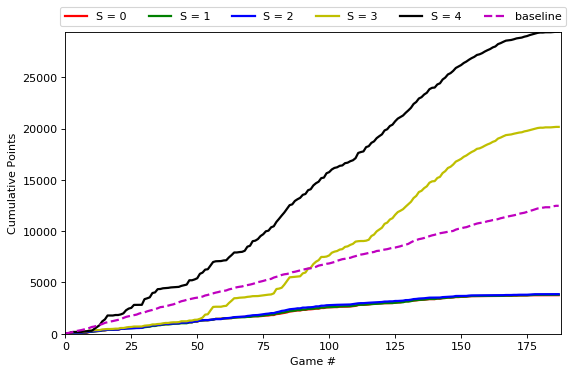

In [0]:
x = range(len(DATES[1:]))
BASELINE_FPs_cumsum = np.cumsum(BASELINE_FPs)
SU_FPs_cumsum = np.cumsum(SU_FPs, axis = 0)
max_index = np.argmax(np.max(SU_FPs_cumsum, axis = 0))

fig = plt.figure(figsize = (8, 5), dpi = 80)
ax1 = fig.add_subplot(111)

ax1.plot(x, SU_FPs_cumsum[:,0], c = 'r', label = 'S = 0', linewidth = 2)
ax1.plot(x, SU_FPs_cumsum[:,1], c = 'g', label = 'S = 1', linewidth = 2)
ax1.plot(x, SU_FPs_cumsum[:,2], c = 'b', label = 'S = 2', linewidth = 2)
ax1.plot(x, SU_FPs_cumsum[:,3], c = 'y', label = 'S = 3', linewidth = 2)
ax1.plot(x, SU_FPs_cumsum[:,4], c = 'k', label = 'S = 4', linewidth = 2)
ax1.plot(x, BASELINE_FPs_cumsum, c = 'm', label = 'baseline', linewidth = 2, linestyle='--')

ax1.set_xlabel('Game #')
ax1.set_ylabel('Cumulative Points')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, ncol=6);
plt.xlim([0, len(x)])
plt.ylim([0, np.max(SU_FPs_cumsum)])

plt.show()

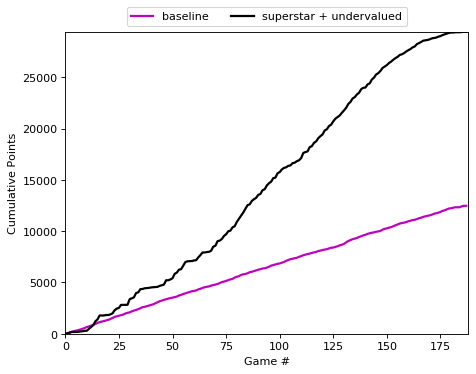

In [0]:
fig = plt.figure(figsize = (6.5, 5), dpi = 80)
ax1 = fig.add_subplot(111)

BASELINE_FPs_cumsum = np.cumsum(BASELINE_FPs)
ax1.plot(x, BASELINE_FPs_cumsum, c = 'm', label = 'baseline', linewidth = 2)
ax1.plot(x, SU_FPs_cumsum[:,max_index], c = 'k', label = 'superstar + undervalued', linewidth = 2)

ax1.set_xlabel('Game #')
ax1.set_ylabel('Cumulative Points')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, ncol=5);
plt.xlim([0, len(x)])
plt.ylim([0, max([np.max(SU_FPs_cumsum), max(BASELINE_FPs_cumsum)])])

plt.show()